# N-band simulation of image source

In [1]:
import numpy as np
from astropy.io import fits
import simmetis as sim

In [2]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

This notebook demonstrates how to run a simulation with SimMETIS when the source structure is provided in the shape of one or several images. Each image is associated with a spectrum. The resulting `Source` object can be thought of as a cube, which is the sum of the images weighted with their associated spectrum. 

The object will be observed in the N2 band. We start by setting up a `UserCommands` structure to configure SimMETIS to use the NQ imaging instrument setup:

In [3]:
cmds = sim.UserCommands('metis_image_NQ.config')

## Setting up the source

The source is a simulation of an AGN torus from Schartmann et al. (2014). It is provided in the form of an image, where pixel values are given in Jy/pixel at a wavelength of 12 micron:

In [4]:
with fits.open("sd0615_image_l12_i090_p000.fits") as inhdul:
    sourceimg = inhdul[0].data
    sourcehdr = inhdul[0].header
    
print("Pixel unit:", sourcehdr['BUNIT'])
print("Wavelength:", sourcehdr['LAMBDA1'])

Pixel unit: JY/PIXEL
Wavelength: 1.2e-05


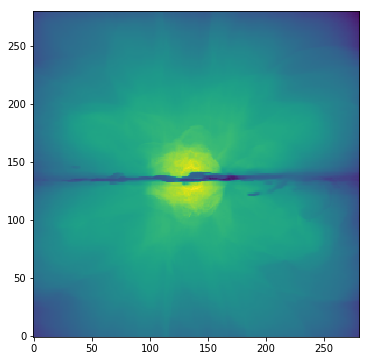

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(sourceimg[120:401, 120:401], norm=LogNorm(), origin='lower')

The pixel scale is 0.5 mas:

In [6]:
print("Pixel scale:", sourcehdr['CDELT1'] * 3600)

Pixel scale: 0.000501151066291764


At this pixel scale, the source will not be resolved by METIS, we will instead assume a pixel scale of 5 mas:

In [7]:
pixscale = 0.005    # arcsec
#pixscale = sourcehdr['CDELT1'] * 3600

We have not been provided with a spectrum for this image. For simplicity we will assume a flat spectrum (in $f_{\lambda}$), which can be created with the function `sim.source.flat_spectrum`. As the image pixel values are in Jy, we need to scale the spectrum such that, at $\lambda=12\,$micron, it has a value corrsponding to 1 Jy:

In [8]:
from astropy import units as u
flam_ref = (1 * u.Jy).to(u.ph * u.s**-1 * u.m**-2 * u.um**-1, 
                  equivalencies=u.spectral_density(12 * u.um))
print("1 Jy at 12 um corresponds to", flam_ref)

1 Jy at 12 um corresponds to 1257658.5039136314 ph / (m2 s um)


The spectral flux is expected to be given in units of photons / (s m2 arcsec**2 bin):

In [9]:
dlam = 0.01  # [um], spectral bin width
lam = sim.utils.seq(10, 13.2, dlam)
flux = np.ones_like(lam) * flam_ref * dlam #/ cmds['SIM_DETECTOR_PIX_SCALE']**2

We can now read in the image and construct the SimMETIS `Source` object using the function `sim.source.source_from_image`. The `oversample` parameter is necessary to prevent aliasing due to the way that images are currently handled in SimMETIS.

In [10]:
src = sim.source.source_from_image(sourceimg, lam, flux, 
                                   plate_scale=pixscale, oversample=4)

# Setting up and running the simulation

Set up the instrument to use the N2 filter:

In [11]:
cmds['INST_FILTER_TC'] = 'TC_filter_N2.dat'

Build the optical train and the detector (ignore the warning - SimMETIS is doing the right thing):

In [12]:
opttrain = sim.OpticalTrain(cmds)
fpa = sim.Detector(cmds, small_fov=False)

/home/oczoske/ELT_Development/SimMETIS/simmetis/psf.py:1200: UserWarning: CDELT > 1. Assuming the scale to be [mas]
  warnings.warn("CDELT > 1. Assuming the scale to be [mas]")
/home/oczoske/VirtualEnvs/simenv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Now apply the optical train to the source object. This creates an ideal image just in front of the detector with units of photons per second per pixel.

In [13]:
src.apply_optical_train(opttrain, fpa)

Generating image for chip 1


To create the simulated detector images we "read out" the detector with various exposure times. The results are FITS HDU objects.

In [14]:
imghdu_1 = fpa.read_out(OBS_EXPTIME=1)
imghdu_100 = fpa.read_out(OBS_EXPTIME=100)
imghdu_3600 = fpa.read_out(OBS_EXPTIME=3600)

Reading out chip 1 using superfast
314424002493513.06 299857899.09045756 300293348.0501045 299857900.44155824
314424050000000.0 299771870.0 300320700.0 299858020.0
Reading out chip 1 using superfast
3.1442400249351308e+16 299857899.09045756 300293348.0501045 299857900.44155824
3.1442427e+16 29984864000.0 30029238000.0 29985794000.0
Reading out chip 1 using superfast
1.131926408976647e+18 299857899.09045756 300293348.0501045 299857900.44155824
1.131926e+18 1079482450000.0 1081055440000.0 1079488500000.0


Save the results to disk:

In [15]:
imghdu_1.writeto("sd0615_METIS_N2_1sec.fits", overwrite=True)
imghdu_100.writeto("sd0615_METIS_N2_100sec.fits", overwrite=True)
imghdu_3600.writeto("sd0615_METIS_N2_3600sec.fits", overwrite=True)

## Looking at the results

Text(0.5, 1.0, 'OBS_EXPTIME=3600')

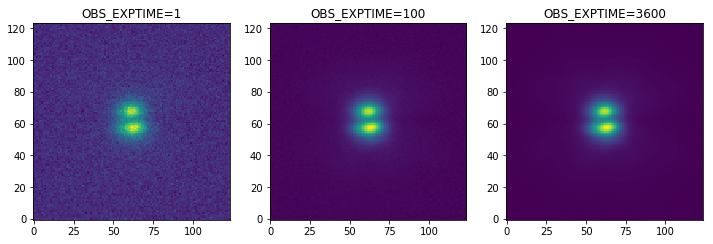

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(imghdu_1[0].data[450:574, 450:574], 
           norm=LogNorm(), origin='lower')
ax1.set_title("OBS_EXPTIME=1")
ax2.imshow(imghdu_100[0].data[450:574, 450:574],
          norm=LogNorm(), origin='lower')
ax2.set_title("OBS_EXPTIME=100")
ax3.imshow(imghdu_3600[0].data[450:574, 450:574],
          norm=LogNorm(), origin='lower')
ax3.set_title("OBS_EXPTIME=3600")

Look at a few numbers. We'll define a mask for the object: 

In [17]:
ny, nx = imghdu_1[0].data.shape
i, j = np.meshgrid(np.arange(nx), np.arange(ny))
icen, jcen = 511.5, 511.5

# apertures for source and background
srcmask = ((i - icen)**2 + (j - jcen)**2 < 365**2)  # radius 365 pixels
bgmask = np.logical_not(srcmask)
n_src = np.sum(srcmask)     # number of pixels in aperture
n_bg = np.sum(bgmask) # number of pixels outside aperture

In [18]:
images = [imghdu_1[0].data, imghdu_100[0].data, imghdu_3600[0].data]
T_exp = np.array([1, 100, 3600])

In [19]:
bg_counts = np.array([np.mean(img[bgmask]) for img in images])
print("   T_exp     counts    counts/sec")
for T, bg in zip(T_exp, bg_counts):
    print("{:>4} sec:  {:8.2g}   {:.2f}".format(T, bg, bg / T))

   T_exp     counts    counts/sec
   1 sec:     3e+08   299857909.82
 100 sec:     3e+10   299857900.42
3600 sec:   1.1e+12   299857900.29


In [20]:
src_counts = np.array([np.sum(img[srcmask] - bg) 
                       for img, bg in zip(images, bg_counts)])
print("   T_exp     counts     counts/sec")
for T, cts in zip(T_exp, src_counts):
    print("{:>4} sec:  {:8.2g}   {:.2f}".format(T, cts, cts / T))

   T_exp     counts     counts/sec
   1 sec:   2.1e+08   206129509.38
 100 sec:   2.1e+10   206089943.32
3600 sec:   7.4e+11   205091471.75


## Varying airmasses

The images above were simulated for airmass 1.0. Do the exercise for varying airmass (exposure time 3600 s):

In [21]:
airmass = [1.0, 1.3, 2.0]

In [22]:
hdus_am = []
opttrains = []
for airm in airmass:
    print("Working on airmass", airm)
    cmds['ATMO_AIRMASS'] = airm
    opttrains.append(sim.OpticalTrain(cmds))
    fpa = sim.Detector(cmds, small_fov=False)
    src.apply_optical_train(opttrains[-1], fpa)
    hdus_am.append(fpa.read_out(OBS_EXPTIME=3600.))
    hdus_am[-1].writeto("sd0615_METIS_N2_3600_" + str(airm) + ".fits", overwrite=True)

Working on airmass 1.0
Generating image for chip 1
Reading out chip 1 using superfast
1.131926408976647e+18 299857899.09045756 300293348.0501045 299857900.44155824
1.131926e+18 1079483600000.0 1081056170000.0 1079488500000.0
Working on airmass 1.3
Generating image for chip 1
Reading out chip 1 using superfast
1.1610283039586783e+18 307567270.57807165 307998127.35280615 307567271.91480786
1.1610299e+18 1107236900000.0 1108792200000.0 1107242300000.0
Working on airmass 2.0
Generating image for chip 1
Reading out chip 1 using superfast
1.2211133473182966e+18 323484376.2675362 323904395.3897295 323484377.57028747
1.221112e+18 1164538800000.0 1166058200000.0 1164543800000.0


In [23]:
images_am = [hdu[0].data for hdu in hdus_am]
background_am = [np.mean(img[bgmask]) for img in images_am]
print("airmass   counts")
for airm, bg in zip(airmass, background_am):
    print("{}     {}".format(airm, bg))

airmass   counts
1.0     1079488439451.7521
1.3     1107242175435.2332
2.0     1164543759610.8313


In [24]:
src_am = [np.sum(img[srcmask] - bg) for img, bg in zip(images_am, background_am)]
print("airmass   counts")
for airm, ct in zip(airmass, src_am):
    print("{}     {}".format(airm, ct))

airmass   counts
1.0     737982609311.373
1.3     732514895127.207
2.0     711834645286.2617
